## Çok sınıflı sınıflandırma (Multiclass classification)

* Önceki görevde ikili (binary) bir sınıflandırma problemini çözdük.  
* Peki ya **çok sınıflı (multiclass) bir sınıflandırma problemi**?

🎯 Egzersizin Amaçları:
- Çok sınıflı bir sınıflandırma problemi için tasarlanmış bir Sinir Ağı (Neural Network) yazmak
- Bu modelin ne kadar kolay **overfit** olabileceğini gözlemlemek… !

## (1) Bir `Blobs` veri kümesi oluşturun

📚 Sklearn’deki **`make_blobs`** fonksiyonu [(dokümantasyona bakınız)](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) aşağıdakileri üretmenize olanak tanır:
- İstenilen sayıda veri örneği (`n_samples` parametresi)
- Her veri örneği için istenilen sayıda özellik (`n_features` parametresi)
- İstenilen sayıda sınıf/kategori (`centers` parametresi)
- Sınıflar arasındaki mesafe (`cluster_std` parametresi)

💡 Ayrıca, verinin **deterministik** olarak (aynı şekilde) üretilmesini ve tekrar edilebilir olmasını sağlayan `random_state` parametresi de vardır.


❓ Belgelere göre:

👽 Aşağıdakilerle bir ***blobs*** veri kümesi oluşturun:
- 1200 örnek
- Örnek başına 8 özellik
- 7 veri kategorisi
- Kategoriler arasındaki mesafe 8

🔮 1'e eşit bir `random_state` seçin.

📏 Şekli yazdırın ve `X` için (1200, 8) ve `y` için (1200,) ile eşleştiğini kontrol edin ❓

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
import tensorflow as tf
from tensorflow import keras

X, y = make_blobs(
    n_samples=1200,
    n_features=8,
    centers=7,
    cluster_std=1.0,
    center_box=(-8, 8),
    random_state=1
)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1200, 8)
y shape: (1200,)


❓ _matplotlib_ kullanarak bu blob veri kümesinin iki (rastgele) boyutunun dağılım grafiğini çizin. Her nokta, ait olduğu kategoriye göre renklendirilmelidir. ❓

Dimensions chosen: 7 & 2


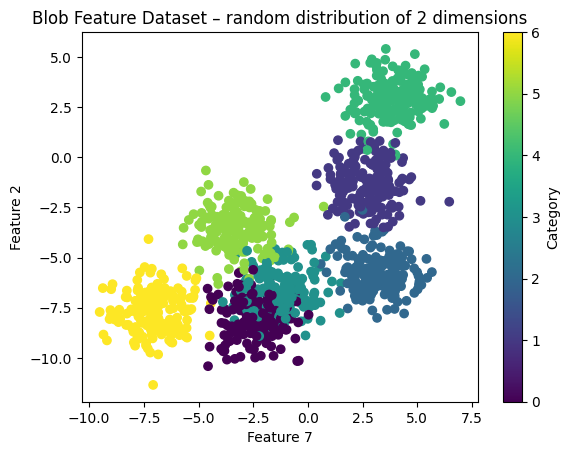

In [6]:
X, y = make_blobs(
    n_samples=1200,
    n_features=8,
    centers=7,
    cluster_std=1.0,
    center_box=(-8, 8),
    random_state=1
)
np.random.seed(1)  
dims = np.random.choice(X.shape[1], size=2, replace=False)

dim1, dim2 = dims
print(f"Dimensions chosen: {dim1} & {dim2}")


plt.figure()
scatter = plt.scatter(
    X[:, dim1],
    X[:, dim2],
    c=y
)

plt.xlabel(f"Feature {dim1}")
plt.ylabel(f"Feature {dim2}")
plt.title("Blob Feature Dataset – random distribution of 2 dimensions")
plt.colorbar(scatter, label="Category")
plt.show()




❓ Diğer boyutlarda da aynı işlemi tekrarlayın. Veri noktalarının kolayca ayrılmadığını görsel olarak görebilirsiniz ❓

Total number of graphs: 28


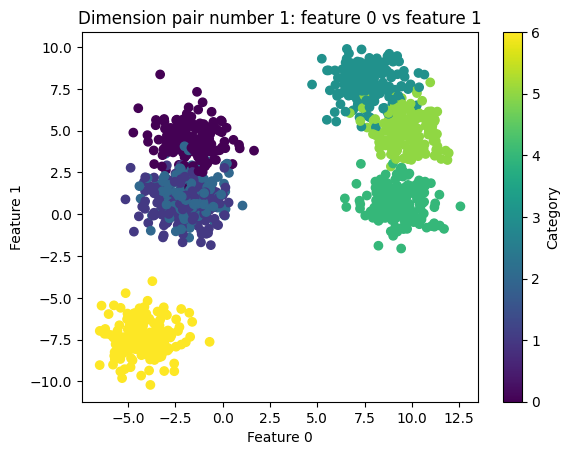

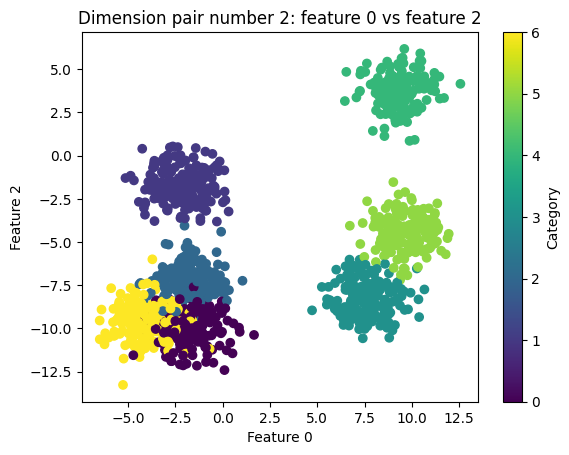

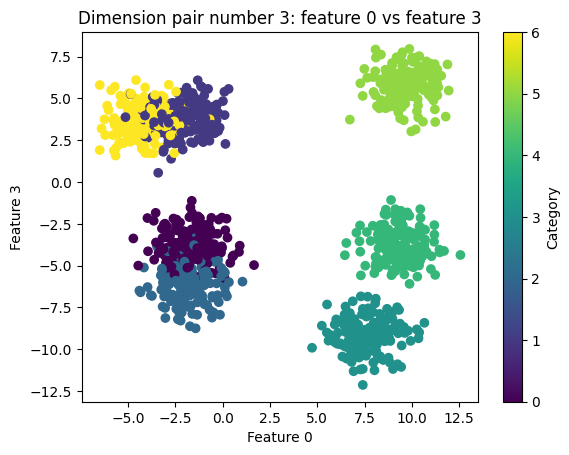

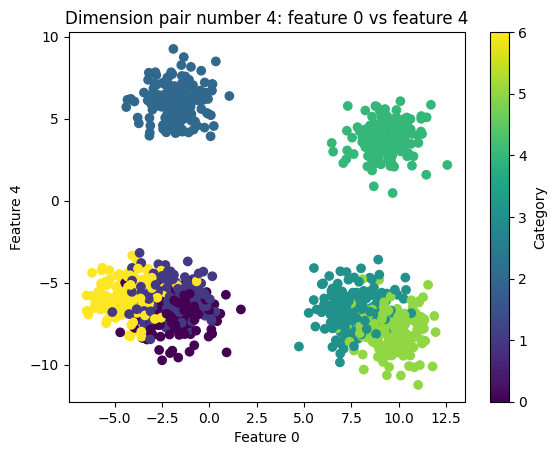

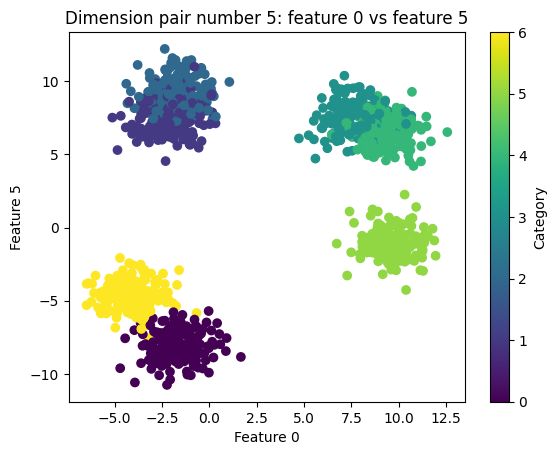

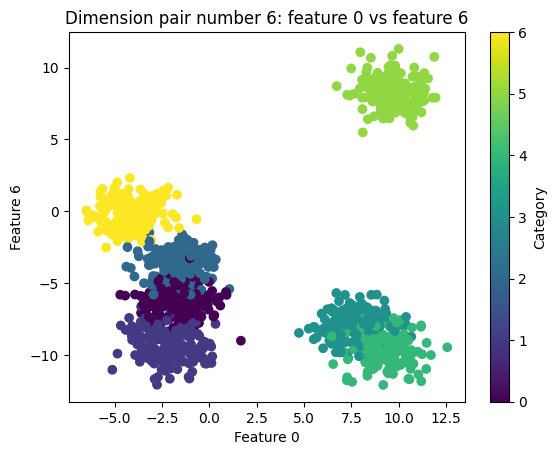

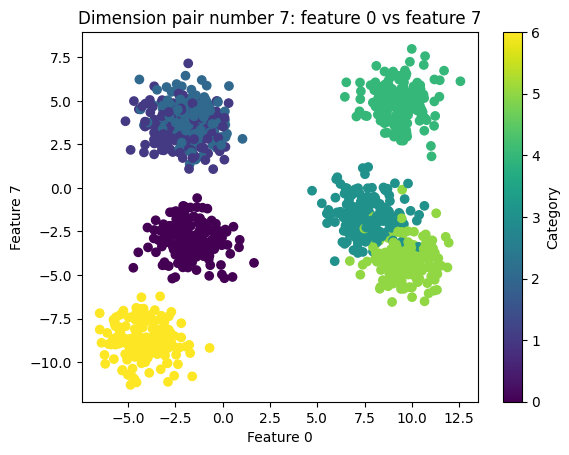

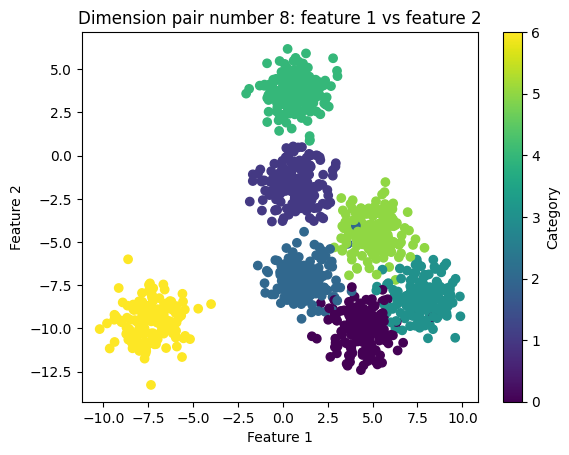

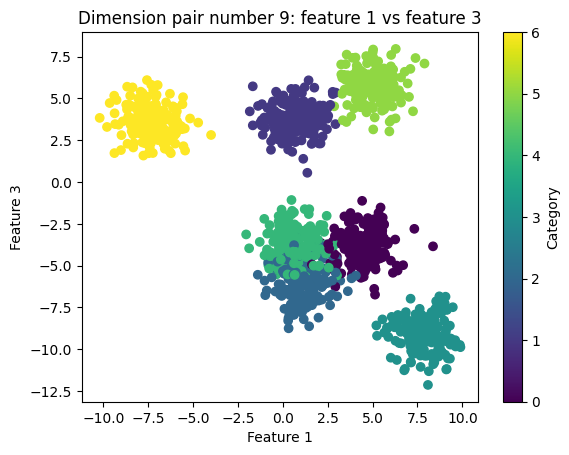

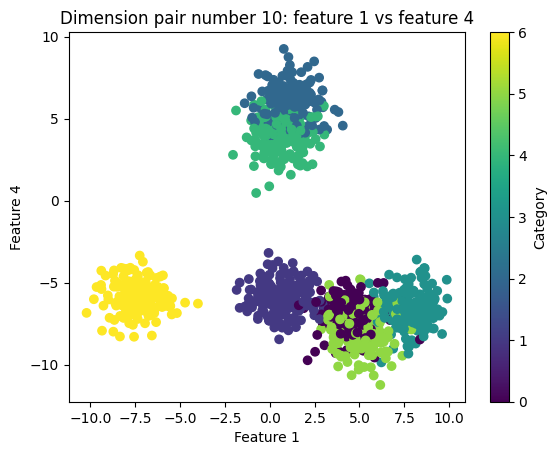

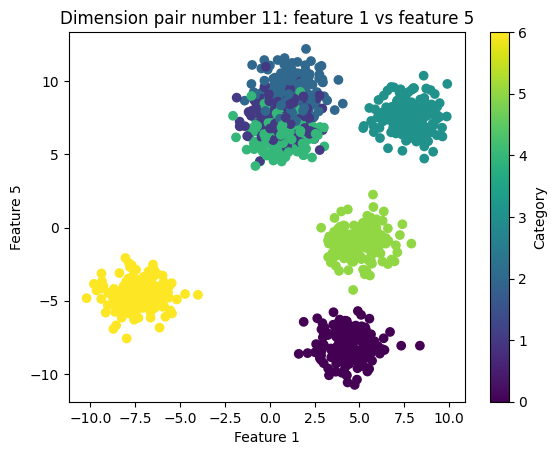

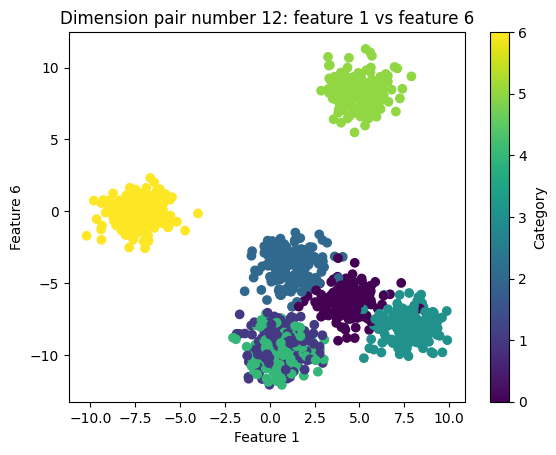

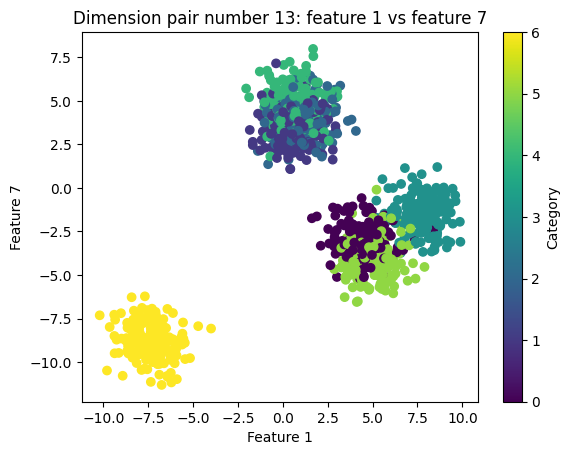

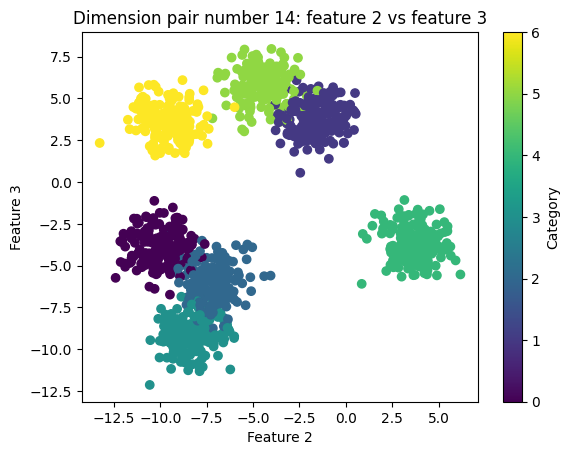

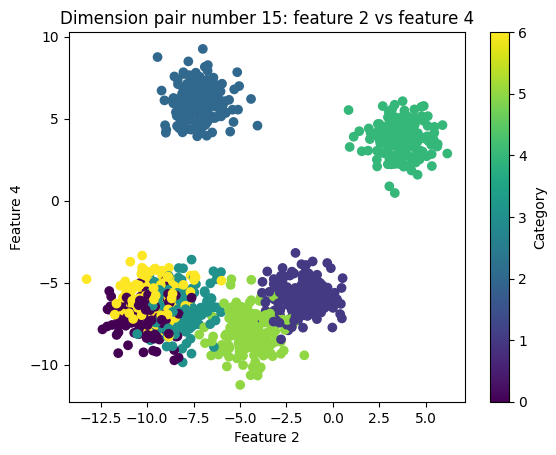

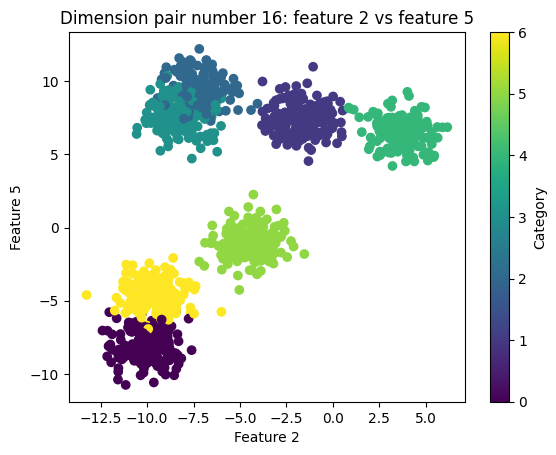

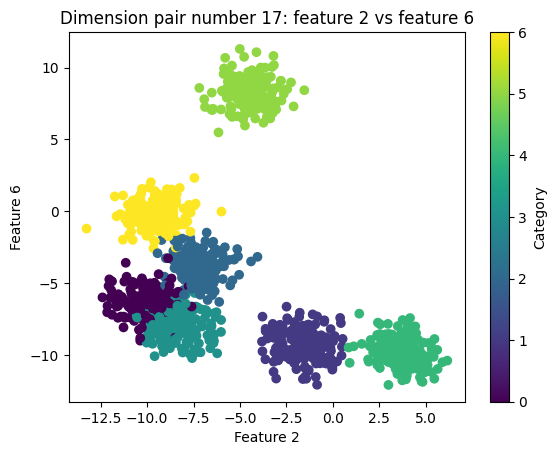

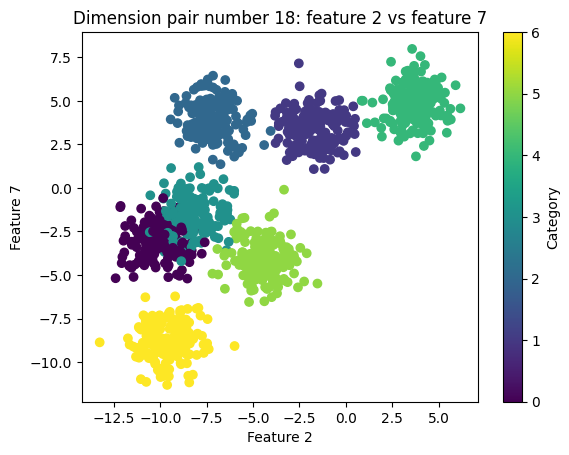

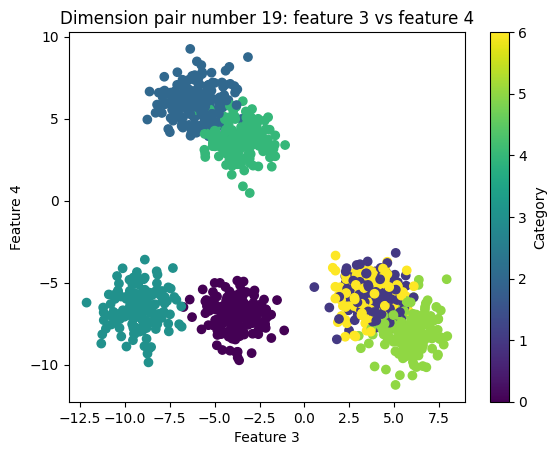

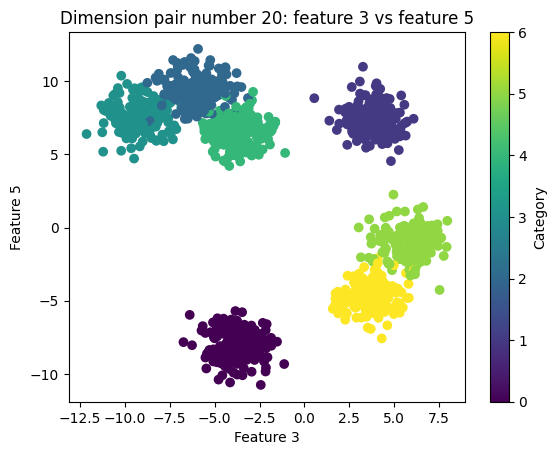

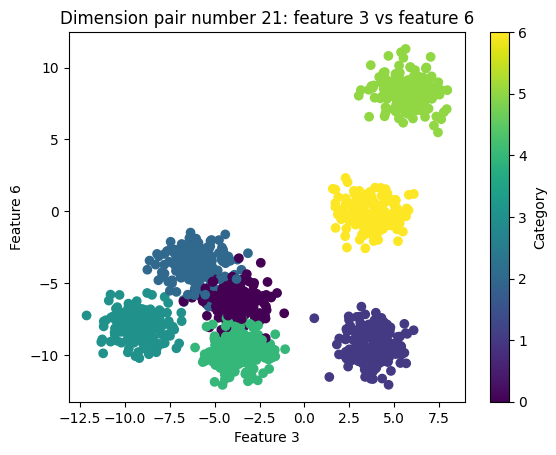

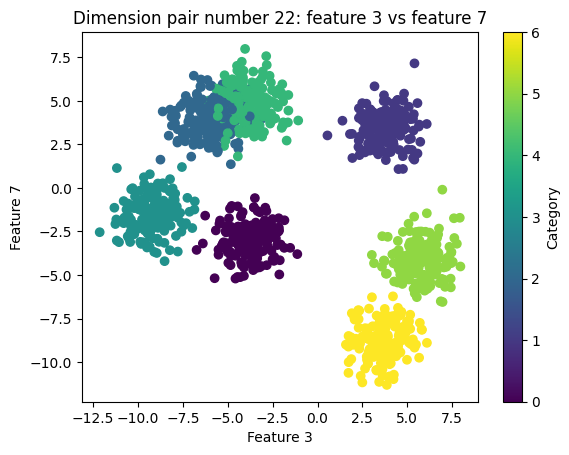

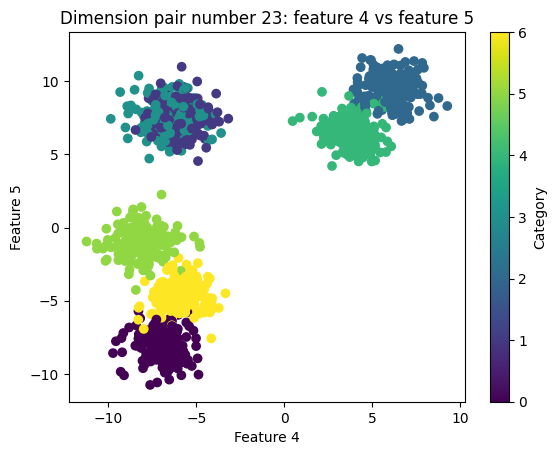

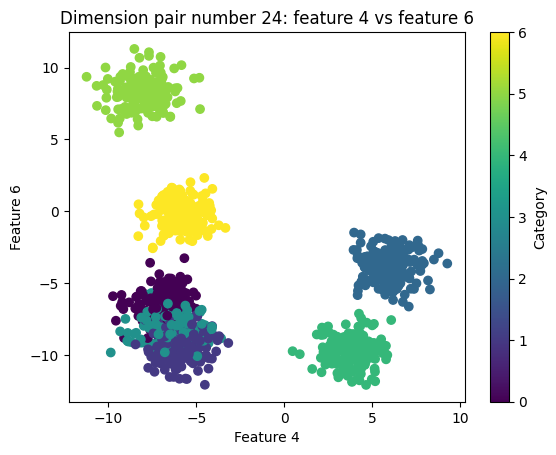

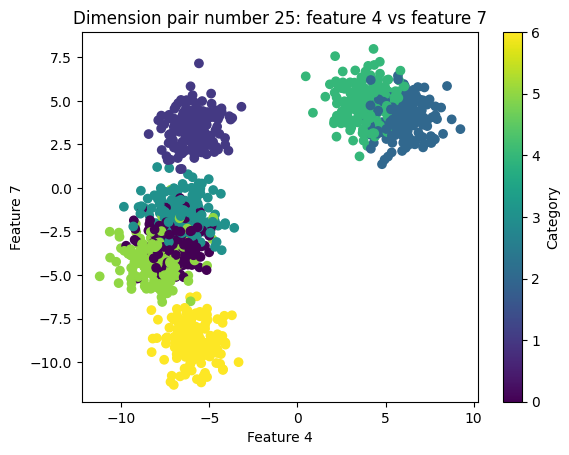

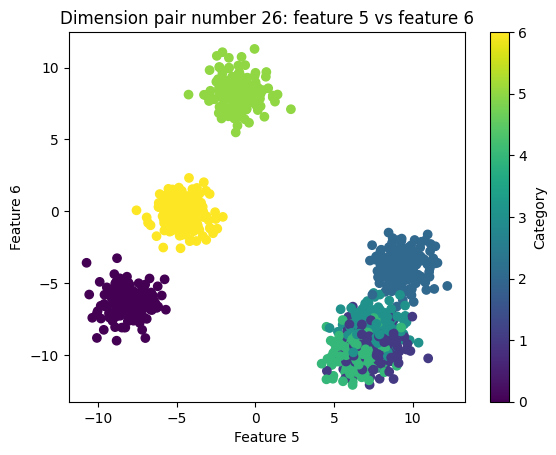

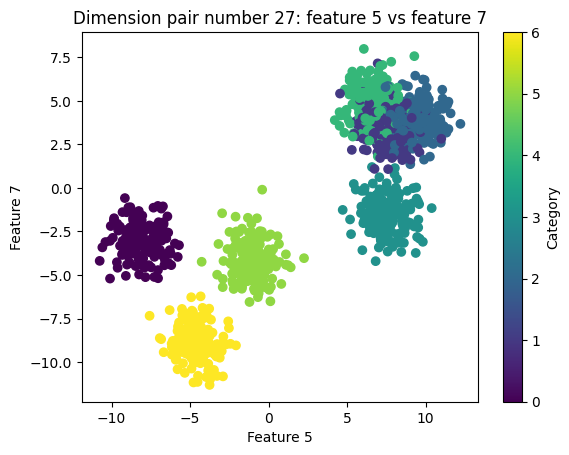

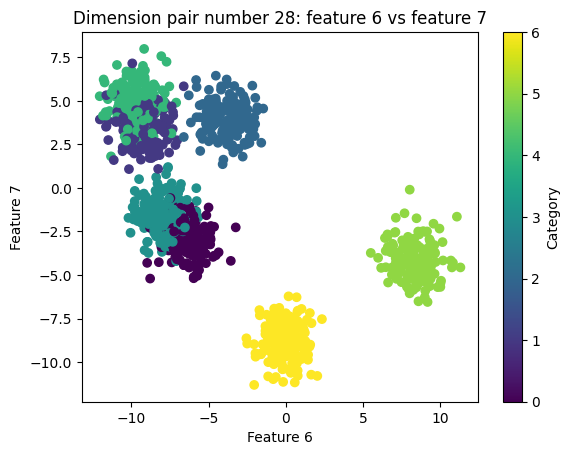

In [7]:
from itertools import combinations

X, y = make_blobs(
    n_samples=1200,
    n_features=8,
    centers=7,
    random_state=1
)

feature_pairs = list(combinations(range(X.shape[1]), 2))
print("Total number of graphs:", len(feature_pairs))

for i, (dim1, dim2) in enumerate(feature_pairs, start=1):
    plt.figure()
    scatter = plt.scatter(
        X[:, dim1],
        X[:, dim2],
        c=y
    )
    
    plt.xlabel(f"Feature {dim1}")
    plt.ylabel(f"Feature {dim2}")
    plt.title(f"Dimension pair number {i}: feature {dim1} vs feature {dim2}")
    plt.colorbar(scatter, label="Category")
    plt.show()



## (2) Çok sınıflı sınıflandırma probleminin hedefini kodlama

👉 Şu an için hedef `y`, giriş verisinin ait olduğu kategoriyi temsil eden **tamsayılar listesidir**. Şöyle görünür:  
`[3, 2, 2, 3, 0, 5, 1, 1, 0, 5, ...]`  
(bu örnekte 0’dan 6’ya kadar **7 kategori** vardır).

🧑🏻‍🏫 Ancak **Tensorflow/Keras’ta kategorik problemler için hedef/çıktı (`target/output`) aşağıdaki şekilde encode edilmelidir**:

```
[
[0, 0, 0, 1, 0, 0, 0], 
[0, 0, 1, 0, 0, 0, 0], 
[0, 0, 1, 0, 0, 0, 0], 
[1, 0, 0, 0, 0, 0, 0], 
[0, 0, 0, 0, 0, 1, 0], 
[0, 1, 0, 0, 0, 0, 0],
[0, 1, 0, 0, 0, 0, 0],
[1, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 1],
...
]
```


Burada:
- satır sayısı, **gözlem sayısına** eşittir  
- sütun sayısı, **farklı kategori sayısına** eşittir  

👉 Her sütun bir **kategoriyi** temsil eder.  

👉 Her satır bir **hedefi** temsil eder; `1` değeri, giriş verisinin ait olduğu kategoriyi gösterir.  

Bir satırı, olasılık vektörü olarak düşünebilirsiniz.

```
Örnek:
| Cat 0 | Cat 1 | Cat 2 | Cat 3 | Cat 4 | Cat 5 | Cat 6 |
|-------|-------|-------|-------|-------|-------|-------|
| 0     | 0     | 0     | 1     | 0     | 0     | 0     |

Bu, ilgili satırın %100 olasılıkla Cat 3’e ait olduğu anlamına gelir.
Cat 3
```


---

💡 `y`’yi kategorik hale dönüştürmek için **Tensorflow/Keras içindeki `to_categorical`** fonksiyonunu kullanın.

<details>
    <summary><i>Tensorflow/Keras’taki <code>to_categorical</code> ile Scikit-Learn’deki <code>OneHotEncoder</code> arasında bir benzerlik var mı?</i></summary>

Evet! **`to_categorical`**, Sklearn’deki `OneHotEncoder` gibi çalışır;  
ancak burada bir **kategorik feature** değil, **kategorik target (hedef)** encode edilir.

</details>

---

❓ **Kategorik hedefin kodlanması**:  `y` yazdırın, ardından *to_categorical* işlevini *`y`* üzerinde uygulayın ve *y'nin kategorize edilmiş halini* `y_cat` adlı bir değişkene kaydedin. ❓

In [8]:
from tensorflow.keras.utils import to_categorical

#print(y)
y_cat = to_categorical(y)
print(y_cat)
print("Shape of y:",y.shape)
print("Shape of y_cat:",y_cat.shape)


[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
Shape of y: (1200,)
Shape of y_cat: (1200, 7)


## (3) Çok Sınıflı Sınıflandırma Görevi için Sinir Ağı

❓ **Hold-out yöntemi**: Veri kümesi $X$ ve $y_{cat}$ 'i _train_ ve _test_ kümelerine ayırın (boyut: 70/30%)

Not: Değişkenleri `X_train`, `X_test`, `y_train` ve `y_test` olarak adlandırın ❓

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_cat,        
    test_size=0.30,
    random_state=1,
    shuffle=True
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (840, 8)
X_test shape: (360, 8)
y_train shape: (840, 7)
y_test shape: (360, 7)


Derin Öğrenmede, herhangi bir Makine Öğrenimi algoritmasında olduğu gibi, sayısal özellikleriniz ölçeklendirilmelidir.

❓ **Ölçeklendirme**: Eğitim kümesine bir Sklearn [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) uydurun ve hem eğitim kümenizi hem de test kümenizi dönüştürün ❓

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)


X_train_scaled shape: (840, 8)
X_test_scaled shape: (360, 8)


❓ **Modeli başlatma**: Aşağıdaki işlevi tamamlayarak aşağıdaki özelliklere sahip bir model oluşturun/başlatın:
- İlk katman:
   - 50 nöron
   - `relu` aktivasyonu
   - Doğru giriş boyutu
- Çıkış katmanı:
   - Çok sınıflı sınıflandırma görevi için tasarlanmış
   - Her sınıfa ait olma olasılıklarını çıktı olarak veren ❓

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input

def initialize_model():

    #############################
    #  1 - Model mimarisi   #
    #############################
    model = Sequential([
       Input(shape=(8,)),
       Dense(50, activation="relu"), 
       Dense(7, activation="softmax")
])
   

    #############################
    #  2 - Optimizasyon Yöntemi #
    #############################
    model.compile(loss='categorical_crossentropy', # binary_crossentropy'den farklıdır çünkü birden fazla sınıfımız vardır
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


model = initialize_model()

❓  Modelde kaç parametre (diğer adıyla ağırlık) vardır? ❓

In [12]:
num_of_params = 807
num_of_params

807

❓ **Modeli uydurma**: Modelinizi 50 dönemlik tren verilerine uydurun ve geçmişi çizin ❓

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3185 - loss: 1.6867 - val_accuracy: 0.6845 - val_loss: 1.4567
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8765 - loss: 1.2724 - val_accuracy: 0.9881 - val_loss: 1.0812
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.9351 - val_accuracy: 1.0000 - val_loss: 0.7815
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.6706 - val_accuracy: 1.0000 - val_loss: 0.5529
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.4731 - val_accuracy: 1.0000 - val_loss: 0.3882
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.3329 - val_accuracy: 1.0000 - val_loss: 0.2733
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.2380 - val_accuracy: 1.0000 - val_loss: 0.1984
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.1747 - val_accuracy: 1.0000 - val_loss

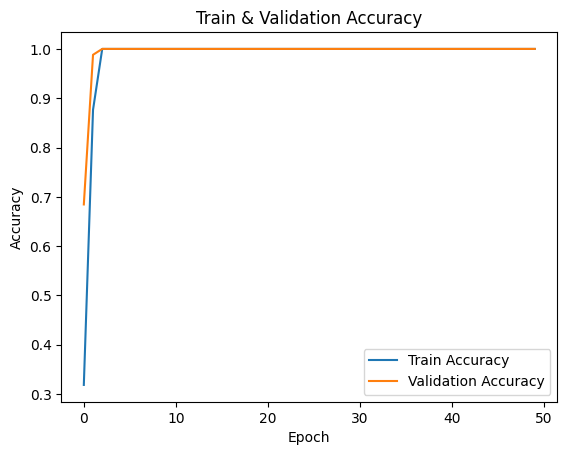

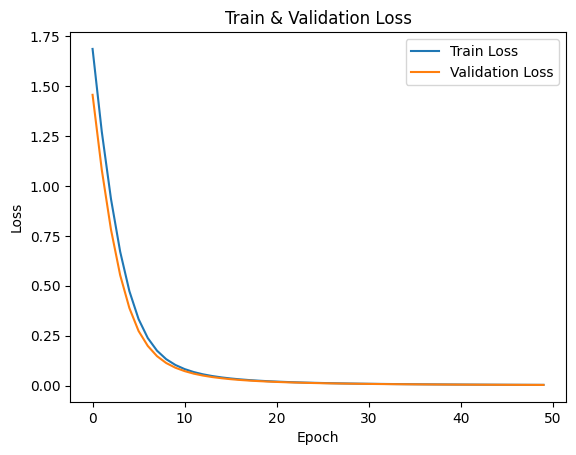

In [13]:
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


plt.figure()
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train & Validation Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss")
plt.legend()
plt.show()





❓ **Değerlendirme**:  Modelinizi test setinde değerlendirin ve doğruluğu yazdırın ❓

In [14]:
test_loss, test_accuracy = model.evaluate(
    X_test_scaled,
    y_test,
    verbose=0
)

print(f"Test accuracy: {test_accuracy:.2f}")



Test accuracy: 1.00


❓ 🤔 Bu iyi bir puan mı? Bunu bir tür karşılaştırma değeriyle karşılaştırmalısınız. Bu durumda, rastgele bir tahminle ne kadar puan elde edilebilir? Bu temel puanı `accuracy_baseline` değişkeninde saklayın. ❓

(Bunun için kod yazmanıza gerek yok, sadece veri setimizin nasıl oluşturulduğunu düşünün.)

In [15]:
accuracy_baseline = 1/7
accuracy_baseline

0.14285714285714285

🧪 **Kodunu Test Et**

In [16]:
from nbresult import ChallengeResult
result = ChallengeResult('baseline',
                         accuracy=accuracy_baseline)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/zeynepdil/.pyenv/versions/3.12.9/envs/workintech/bin/python
cachedir: .pytest_cache
rootdir: /home/zeynepdil/code/S18D2-S-Data-multiclass-classification/tests
plugins: typeguard-4.4.2, anyio-4.8.0, dash-3.3.0
collecting ... collected 1 item

test_baseline.py::TestBaseline::test_accuracy PASSED                     [100%]

============================== 1 passed in 0.02s ===============================


💯 You can commit your code:

git add tests/baseline.pickle

git commit -m 'Completed baseline step'

git push origin master



❗ 👀 Bekle ... Kayıp grafiğine daha yakından bakarsan, 50 dönemden sonra da kayıp hala azalmaya devam ediyor gibi görünüyor. Neden bu kadar erken durduruyorsun ❓❗

❓ Modeli yeniden başlatıp bu sefer 1000 dönemle tekrar çalıştıralım ve geçmişi tekrar grafiğe çizelim. ❓

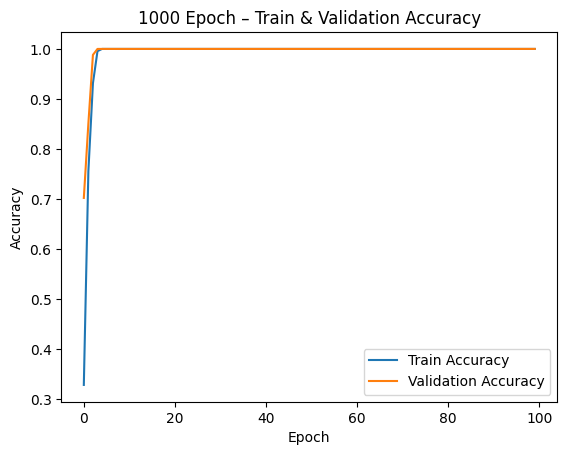

In [24]:
model = initialize_model()
history_1000 = model.fit(
    X_train_scaled,
    y_train,
    epochs=1000,
    batch_size=32,
    validation_split=0.2,
    verbose=0   
)


plt.figure()
plt.plot(history_1000.history["accuracy"], label="Train Accuracy")
plt.plot(history_1000.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("1000 Epoch – Train & Validation Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(history_1000.history["loss"], label="Train Loss")
plt.plot(history_1000.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("1000 Epoch – Train & Validation Loss ")
plt.legend()
plt.show()





❓ **Bir modeli daha uzun süre eğitirken...** ❓
- Yeni kayıp hakkında ne söyleyebilirsiniz?
- Modelinizi test setinde bir kez daha değerlendirin ve doğruluğu yazdırın.

In [25]:
test_loss_1000, test_accuracy_1000 = model.evaluate(
    X_test_scaled,
    y_test,
    verbose=0
)

print(f"Test loss (1000 epoch): {test_loss_1000:.2f}")
print(f"Test accuracy (1000 epoch): {test_accuracy_1000:.2f}")


Test loss (1000 epoch): 0.00
Test accuracy (1000 epoch): 1.00


* 😁 Tren setinde hesaplanan kayıp, 50 epok ile karşılaştırıldığında 1000 epok ile daha küçük görünüyor.
* 😟 Anc ak test setindeki doğruluk, 50 epok ile karşılaştırıldığında 1000 epok ile daha kötü...

❓ Bu fenomene ne denir? ❓

> Overfitting

---

🤔 Bunun olmasını önlemek için ne yapmalıyız? 

<details>
    <summary><i>Olası seçenekler</i></summary>
    

⚠️ Sinir ağlarında aşırı uyumun olmasını önlemek için, örneğin şunları yapabiliriz:
1. Sinir ağının gürültülü veri noktalarından çok fazla öğrenmesini önlemek için ***makul sayıda dönem*** seçin
2. ***Erken Durdurma*** kriteri, yani _.fit()_ 📆 cf. ***Derin Öğrenme > Optimize Ediciler, Kayıp, Uydurma***

</details>    

---


❓ Test kaybının pratikte ne zaman tekrar artmaya başladığını görsel olarak kontrol edelim.  Aşağıdaki komutu çalıştırın ve geçmişi çizin❓

In [28]:
model = initialize_model()

history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    epochs=500,
                    batch_size=16,
                    verbose=0)


😱 Ama durun... test setini kullanırsak hile yapmış olmaz mıyız? Evet, oluruz. Ama yine sabırlı olun. ***Derin Öğrenme - Optimize Ediciler, Kayıp, Uydurma*** bölümünde, bunu önlemek için ***Doğrulama Seti*** adını verdiğimiz şeyi kullanacağız!

🧘🏻‍♀️ Şimdilik, sonraki sorulara geçelim!

❓ **Ağı değerlendirme**: <span style="color:blue">eğitim seti</span> ve <span style="color:orange">test seti</span> üzerindeki kayıp ve doğruluk değerlerini grafik olarak gösterin. Bu konuda ne söyleyebilirsiniz? ❓ 

In [32]:
def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

🤔 Derin Öğrenme modelimiz neden bu kadar kolay aşırı uyum sağlıyor?

😳 Düşünün, sinir ağımız sadece 8 özellik içeren bir veri kümesinden basit bir sınıflandırma görevi için ~800 parametre öğrenmek zorunda! Üstelik, uyum sağlamak için toplamda sadece ~800 veri noktamız var! Model, eğitim kümesindeki her noktanın tam sınıfını neredeyse “öğrenebilir”. 

Buna karşılık, basit bir Lojistik Regresyon, bu blob veri kümesinin kalıplarını yakalamak için sadece 9 parametreyi öğrenmek zorunda kalırdı! 

😏 Derin öğrenme etkileyici bir kavramdır, ancak basit makine öğrenimi görevleri için açıkça aşırı ve gereksiz bir seçenek olabilir!

⭐️ Aşağıdakiler için son derece yararlı olacaktır:
- 📸 Görüntü işleme
- 💹 Zaman serileri
- 🗣 Doğal dil işleme

---

🏁 Tebrikler!

💾 Not defterinizi `git add/commit/push` yapmayı unutmayın...

🚀 ... ve bir sonraki göreve geçin!